### Exploring gradient descent based optimizers

Notebook to understand the working of various gradient descent based optimisers. We'll be exploring the simplest possible supervised learning algorithm as a use case - i.e. linear regression. It helps understand what are the shortcomings of different optimizers and how it is overcome using the newer methods.

Optimizers are used to optimize the model parameters in any learning algorithm. They basically differ in what is the update step given the current parameter values and the gradient values for all parameters. Updating the parameters to minimize loss function is very similar to the real life example of a person trying to reach the bottom of a valley. At any point, you only know where you are, and the directions of maximum change (gradient) in your neighbourhood. You keep moving in direction of maximum downward slope it until you find that the slope is going upward in all your surroundings.

Optimizers added:
* Gradient Descent
* Mini batch gradient descent
* Momentum
* Nesterov
* Adagrad
* Adadelta
* RMSProp
* Adam
* Adamax
* Nadam

Author: Falak Shah

In [1]:
%matplotlib inline

# import stuff 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Synthetically creating points around the line 
$$
y = ax + b
$$
by adding noise to the output. So, effectively,  
$$
y = ax + b + w, \quad where 
$$
$$
w \in N(0, \sigma^2)
$$

In [2]:
# Some global stuff, will be used a lot down the line 
# Do not overwrite these!!
a = 2
b = 25
sigma = 0.5

x = np.arange(-20, 20, 0.05)                       # 40/0.05 = 800 data points
y = a * x + b + sigma * np.random.randn(x.shape[0])

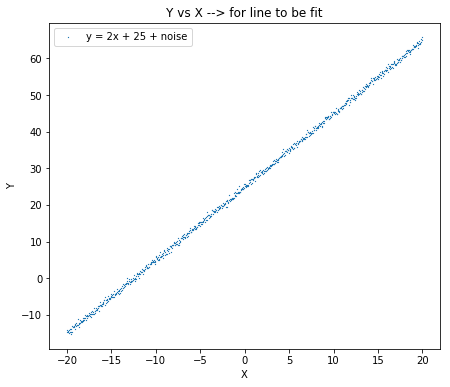

In [3]:
plt.figure(figsize = [7,6])
plt.scatter(x, y, marker='x', s=0.1)
plt.title('Y vs X --> for line to be fit')
plt.xlabel('X'); plt.ylabel('Y')
plt.legend( ['y = ' + str(a) + 'x + ' + str(b) +' + noise'])

The data is shown above. It is basically a line with some gaussian noise added. Here we know the true value of the parameters of the line, i.e. a and b. 


In a supervised learning problem setting, the task would be to determine a and b. We start with some initial pair (a,b) and moving as per the directions of the optimizer till we find the value of (a,b) minimizes the mean squared error over all data points (global minima) or a batch of data points (local minima). 

The loss function can be expressed as: 
$$
loss = \frac{1}{2}\sum_{i=1}^n(y_i - (a x_i + b) )^2 
$$
$$
(a_{opt}, b_{opt}) = \underset{a,b}{\mathrm{argmin}} (loss)
$$
The factor of 1/2 can be discarded without any change in results but is kept for now for ease of gradients computation.

In [4]:
# Compute loss for single a,b or a full grid of them 
def compute_loss(a_est, b_est):
    return np.mean(np.square(y - (a_est * x + b_est)),2)

In [5]:
# Some tricky matrix manipulations in this cell. The main goal is to visualize the loss function for all values of a and b.
a_explore_range = 20
a_explore_step = 0.1

# Since b has less impact on loss function, moving to larger values
b_explore_range = 200
b_explore_step = 1

# Get full ranges of a and b
a_est_range = np.arange(a - a_explore_range, a + a_explore_range, a_explore_step)
b_est_range = np.arange(b - b_explore_range, b + b_explore_range, b_explore_step)

# Make them into a grid. b first, as we want a to change along rows
bgrid, agrid = np.meshgrid(b_est_range, a_est_range)

# I absolutely hate for loops and I know linear algebra, hence this bit of code
size_x = np.int(a_explore_range / a_explore_step * 2)
size_y = np.int(b_explore_range / b_explore_step * 2)
agrid_tiled = np.tile(np.reshape(agrid, [size_x, size_y, 1]), [1,1,x.shape[0]])
bgrid_tiled = np.tile(np.reshape(bgrid, [size_x, size_y,1]), [1,1,x.shape[0]])

# Whoosh! Loss for the full grid at once
loss_full_grid = compute_loss(agrid_tiled, bgrid_tiled)

Text(0.5, 0.92, 'Visualization of the loss function')

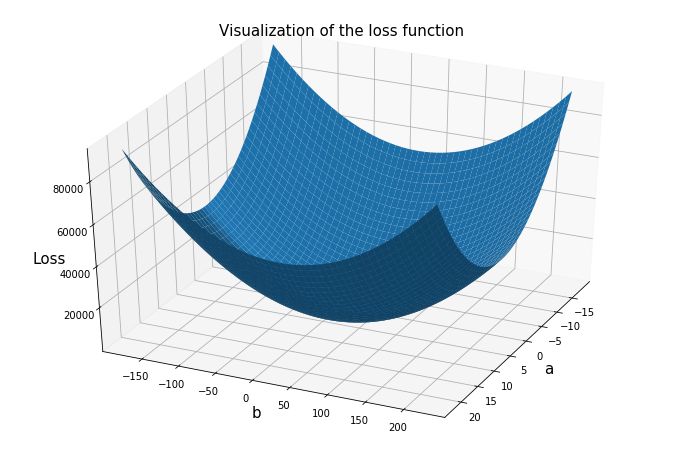

In [6]:
# Change these values and move around the plot to look at it from different angles
azimuth_angle = 25.
elevation_angle = 35

fig = plt.figure(figsize = [12,8])
ax = fig.add_subplot(111, projection = '3d')
ax.view_init(elev = elevation_angle, azim = azimuth_angle)
ax.plot_surface(agrid, bgrid, loss_full_grid)
ax.set_xlabel('a', fontsize=15);  ax.set_ylabel('b', fontsize=15)
ax.set_zlabel('Loss', fontsize=15)
ax.set_title('Visualization of the loss function', fontsize=15)

### The loss function

Observe the loss function across a grid of different parameter values. The blue curve at any point is the loss for a particular set of parameters(a,b) as shown in the figure. Notice how the decline or rise in loss is much steeper when changing a as compared to changing b. This is even more evident in the plots shown below.

Some optimizers have trouble navigating along such loss functions as we'll observe. Also, this curve is obviously convex, and a very clean one at it. Do not expect such clean loss functions in real life.  

Text(0.5, 1.0, 'Mean loss values across for different b values')

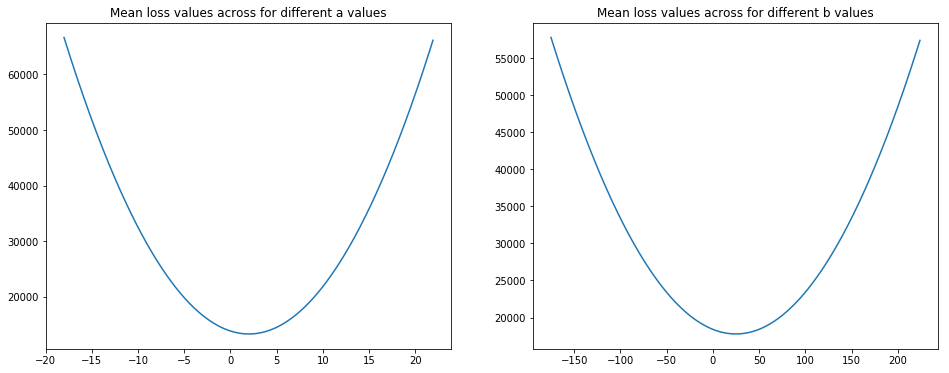

In [7]:
plt.figure(figsize = [16,6])
plt.subplot(121)
plt.plot(a_est_range, np.mean(loss_full_grid, axis=1))
plt.title('Mean loss values across for different a values')
plt.subplot(122)
plt.plot(b_est_range, np.mean(loss_full_grid, axis=0))
plt.title('Mean loss values across for different b values')

### Linear regression problem mathematical formulation

We are trying to fit the line 
$$
y = ax + b
$$
or in other words minimize the loss function
$$
loss = \frac{1}{2}\sum_{i=1}^n(y_i - (a x_i + b) )^2 
$$
$$
loss = \frac{1}{2}\sum_{i=1}^n (y_i^2 + (a x_i)^2 + b^2 + 2ax_ib - 2ax_iy_i - 2y_ib)
$$

### Gradients computation
Computing the gradients w.r.t a and b, we have
$$
\frac{\partial loss}{\partial a} = \frac{1}{2}\sum_{i=1}^n (2ax_i^2 + 2x_ib - 2x_iy_i) 
$$
$$
\frac{\partial loss}{\partial a} = \sum_{i=1}^n x_i (ax_i + b - y_i )
$$
$$
\frac{\partial loss}{\partial b} = \sum_{i=1}^n (ax_i + b - y_i )
$$

In [8]:
# Utility functions  - mostly self explanatory if you read the above ideas

# Hard coded for the line - not a good idea..,but for now
def gradient(x, y, a, b):
    temp_err = a * x + b - y
    loss = sum(temp_err * temp_err)
    grad_a = sum(x * temp_err)
    grad_b = sum(temp_err)
    return (grad_a, grad_b, loss)

# It does what the name says it does..
def get_random_batch(x, y, batch_size):
    i = np.random.randint(0, x.shape[0]-1, size = batch_size)
    return(x[i], y[i])

# Move these below 2 functions out of the notebook!!
def plot_all_results(grad_store, abvalue_store, loss_store, velocity_store = None):
    plt.figure(figsize = [20, 12])
    plt.subplot(231)
    plt.plot(grad_store[:,0])
    plt.title('Gradient in a'); plt.xlabel("# Epochs")
    plt.subplot(232)
    plt.plot(grad_store[:,1])
    plt.title('Gradient in b'); plt.xlabel("# Epochs")
    plt.subplot(233)
    plt.plot(abvalue_store[:,0])
    plt.title('"a" values'); plt.xlabel("# Epochs")
    plt.subplot(234)
    plt.plot(abvalue_store[:,1])
    plt.title('"b" values'); plt.xlabel("# Epochs")
    plt.subplot(235)
    plt.plot(loss_store)
    plt.title("Loss"); plt.xlabel("# Epochs")
    if velocity_store is not None:
        plt.subplot(236)
        plt.plot(velocity_store[:, 0])
        plt.plot(velocity_store[:, 1], 'r*')
        plt.legend(['Velocity of grad_a', 'Velocity of grad_b'])

# Empty spaces for filling in stuff. Storing since we'll need them for plotting
def get_data_stores(num_epochs):
    grad_store = np.zeros([num_epochs, 2], dtype=float)
    abvalue_store = np.zeros([num_epochs, 2], dtype=float)
    loss_store = np.zeros([num_epochs, 1], dtype=float)
    velocity_store = np.zeros([num_epochs, 2], dtype=float)
    
    return grad_store, abvalue_store, loss_store, velocity_store

### Batch Gradient Descent

* Simplest of all optimizers
* Just one parameter - learning rate (denoted by $\eta$)
* Move in the direction opposite of the gradient
* Guaranteed to converge to global optimum (convex function) and local optimum otherwise


**Update rule**
$$
a = a - \eta \frac{\partial(loss)}{\partial{a}} 
$$

**Cons**
* Memory intensive - loads the full dataset and computes gradients


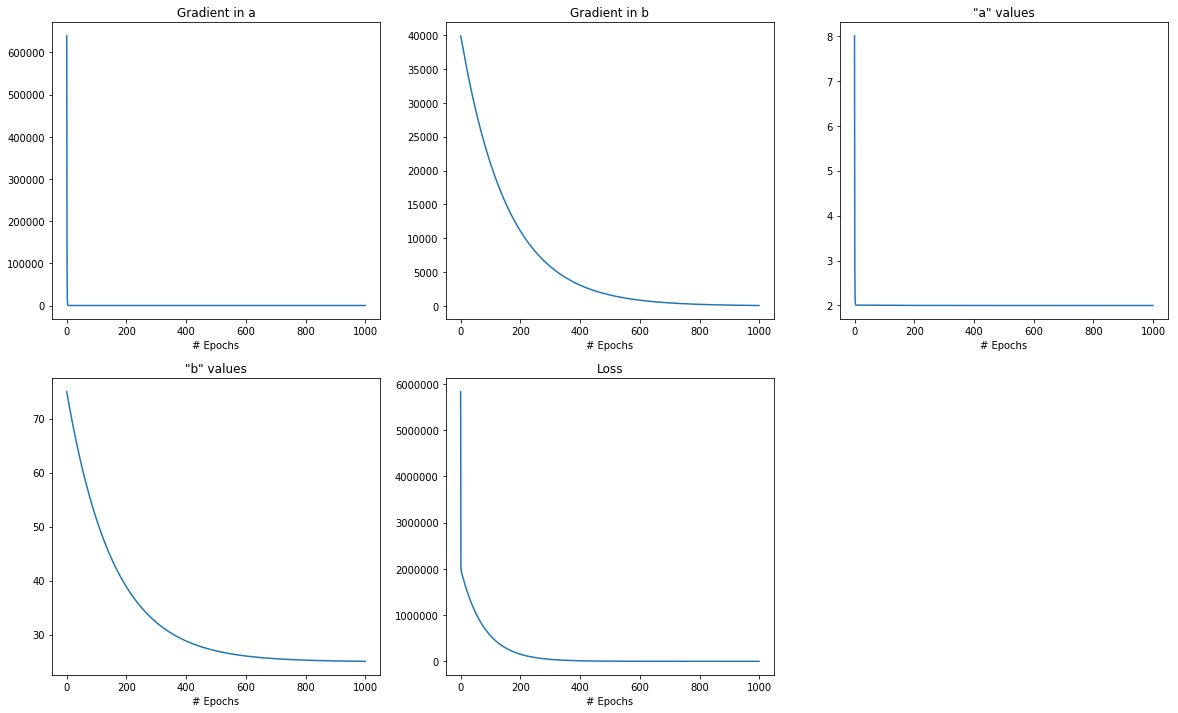

In [9]:
# Batch gradient descent

initial_a = 8
initial_b = 75
num_epochs = 1000
eta = 8e-6

grad_store, abvalue_store, loss_store, _ = get_data_stores(num_epochs)

a_opt = initial_a
b_opt = initial_b
abvalue_store[0,:] = [a_opt, b_opt]

grad_a, grad_b, loss = gradient(x, y, a_opt, b_opt)
grad_store[0,:] = [grad_a, grad_b]
loss_store[0] = loss

for i in range(1,num_epochs):
    a_opt = a_opt - eta * grad_a
    b_opt = b_opt - eta * grad_b
    abvalue_store[i,:] = [a_opt, b_opt]
    
    grad_a, grad_b, loss = gradient(x, y, a_opt, b_opt)
    grad_store[i,:] = [grad_a, grad_b]
    loss_store[i] = loss
    
plot_all_results(grad_store, abvalue_store, loss_store)

### Mini batch gradient descent

This is the same as above gradient descent, except that the update is performed on a mini batch of user specified size. 

* Less memory intensive
* Noisy convergence
* More commonly used in neural nets/ problems that don't fit in memory

**Update rule** 
$$
a = a - \eta \frac{\partial(loss_{batch})}{\partial{a}} \\
$$

where $loss_{batch}$ is the loss over the mini batch under process

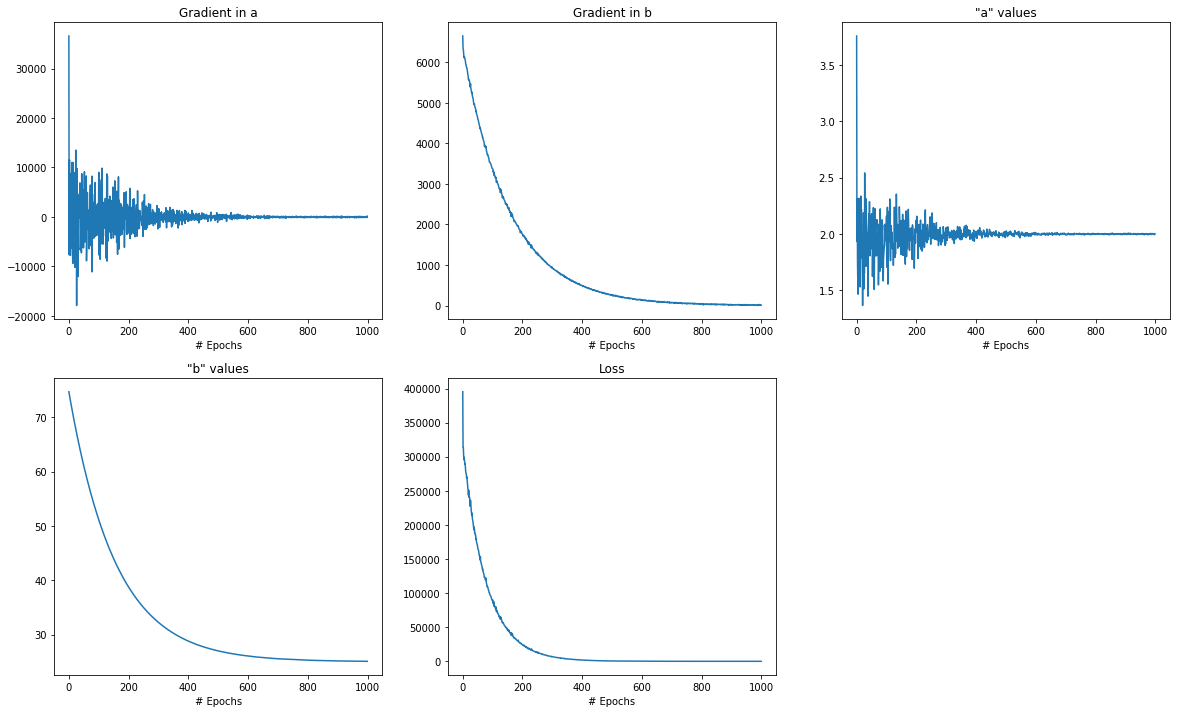

In [10]:
# Mini batch gradient descent

initial_a = 8
initial_b = 75
num_epochs = 1000
learning_rate = 5e-5
batch_size = 128 # Lower this and watch the plots grow messy

grad_store, abvalue_store, loss_store, velocity_store = get_data_stores(num_epochs)

a_opt = initial_a
b_opt = initial_b
abvalue_store[0,:] = [a_opt, b_opt]

x_batch, y_batch = get_random_batch(x,y, batch_size)
grad_a, grad_b, loss = gradient(x_batch,y_batch, initial_a, initial_b)
grad_store[0,:] = [grad_a, grad_b]
abvalue_store[0,:] = [a_opt, b_opt]
loss_store[0] = loss

for i in range(num_epochs):
    a_opt = a_opt - learning_rate * grad_a
    b_opt = b_opt - learning_rate * grad_b
    x_batch, y_batch = get_random_batch(x,y, batch_size)
    grad_a, grad_b, loss = gradient(x_batch, y_batch, a_opt, b_opt)
    grad_store[i,:] = [grad_a, grad_b]
    abvalue_store[i,:] = [a_opt, b_opt]
    loss_store[i] = loss
    
plot_all_results(grad_store, abvalue_store, loss_store)

Observe the noisy convergence in the above case when we used mini batches of data. Vary the batch size parameter above and observe the variations in the result. 

### Momentum

* To lead to faster convergence when gradient changes slowly along one of the dimensions as is the case above

$$
v_t = \gamma v_{t-1} + \eta \frac{\partial loss}{\partial a} 
$$

$$
a = a - v_t
$$

In [11]:
initial_a = 8
initial_b = 75
num_epochs = 1000
eta = 5e-5
batch_size = 128
gamma = 0.9

grad_store, abvalue_store, loss_store, velocity_store = get_data_stores(num_epochs)

a_opt = initial_a
b_opt = initial_b
abvalue_store[0,:] = [a_opt, b_opt]


x_batch, y_batch = get_random_batch(x,y, batch_size)
grad_a, grad_b, loss = gradient(x_batch,y_batch, initial_a, initial_b)
grad_store[0,:] = [grad_a, grad_b]
velocity_a = eta*grad_a
velocity_b = eta*grad_b
velocity_store[0,:] = [velocity_a, velocity_b]
abvalue_store[0,:] = [a_opt, b_opt]
loss_store[0] = loss

for i in range(num_epochs):
    a_opt = a_opt - velocity_a
    b_opt = b_opt - velocity_b
    x_batch, y_batch = get_random_batch(x,y, batch_size)
    grad_a, grad_b, loss = gradient(x_batch, y_batch, a_opt, b_opt)
    velocity_a = gamma* velocity_a + eta * grad_a
    velocity_b = gamma* velocity_b + eta * grad_b
    grad_store[i,:] = [grad_a, grad_b]
    abvalue_store[i,:] = [a_opt, b_opt]
    velocity_store[i,:] = [velocity_a, velocity_b]
    loss_store[i] = loss

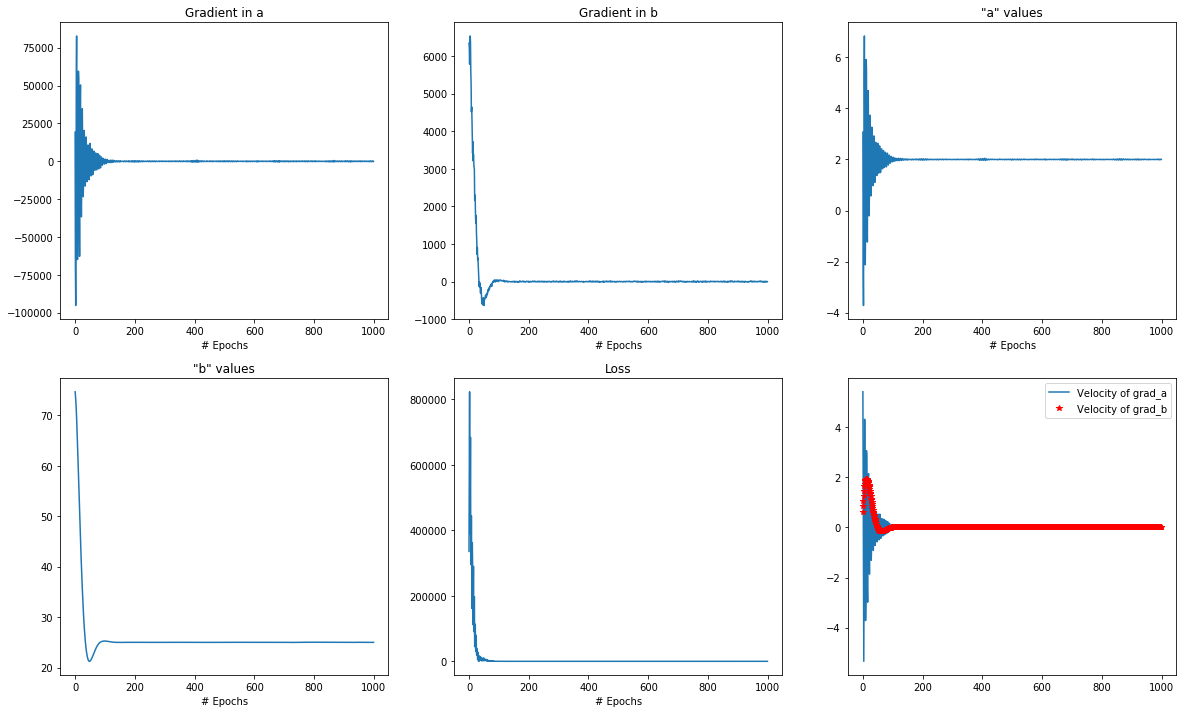

In [12]:
plot_all_results(grad_store, abvalue_store, loss_store, velocity_store)

### Nesterov

* To prevent the ball from sliding up the other slope with all the momentum it gained while coming down

$$
v_t = \gamma v_{t-1} + \eta \frac{\partial loss(a - \gamma v_{t-1})}{\partial a }
$$

$$
a = a - v_t
$$

In [13]:
initial_a = 8
initial_b = 75
num_epochs = 1000
eta = 5e-5
batch_size = 128
gamma = 0.9

grad_store, abvalue_store, loss_store, velocity_store = get_data_stores(num_epochs)

a_opt = initial_a
b_opt = initial_b
abvalue_store[0,:] = [a_opt, b_opt]


x_batch, y_batch = get_random_batch(x,y, batch_size)
grad_a, grad_b, loss = gradient(x_batch,y_batch, initial_a, initial_b)
grad_store[0,:] = [grad_a, grad_b]
velocity_a = eta * grad_a
velocity_b = eta * grad_b
velocity_store[0,:] = [velocity_a, velocity_b]
abvalue_store[0,:] = [a_opt, b_opt]
loss_store[0] = loss

for i in range(num_epochs):
    a_opt = a_opt - velocity_a
    b_opt = b_opt - velocity_b
    x_batch, y_batch = get_random_batch(x,y, batch_size)
    grad_a, grad_b, loss = gradient(x_batch, y_batch, a_opt - gamma * velocity_a, b_opt - gamma * velocity_b)
    velocity_a = gamma * velocity_a + eta * grad_a
    velocity_b = gamma * velocity_b + eta * grad_b
    grad_store[i,:] = [grad_a, grad_b]
    abvalue_store[i,:] = [a_opt, b_opt]
    velocity_store[i,:] = [velocity_a, velocity_b]
    loss_store[i] = loss

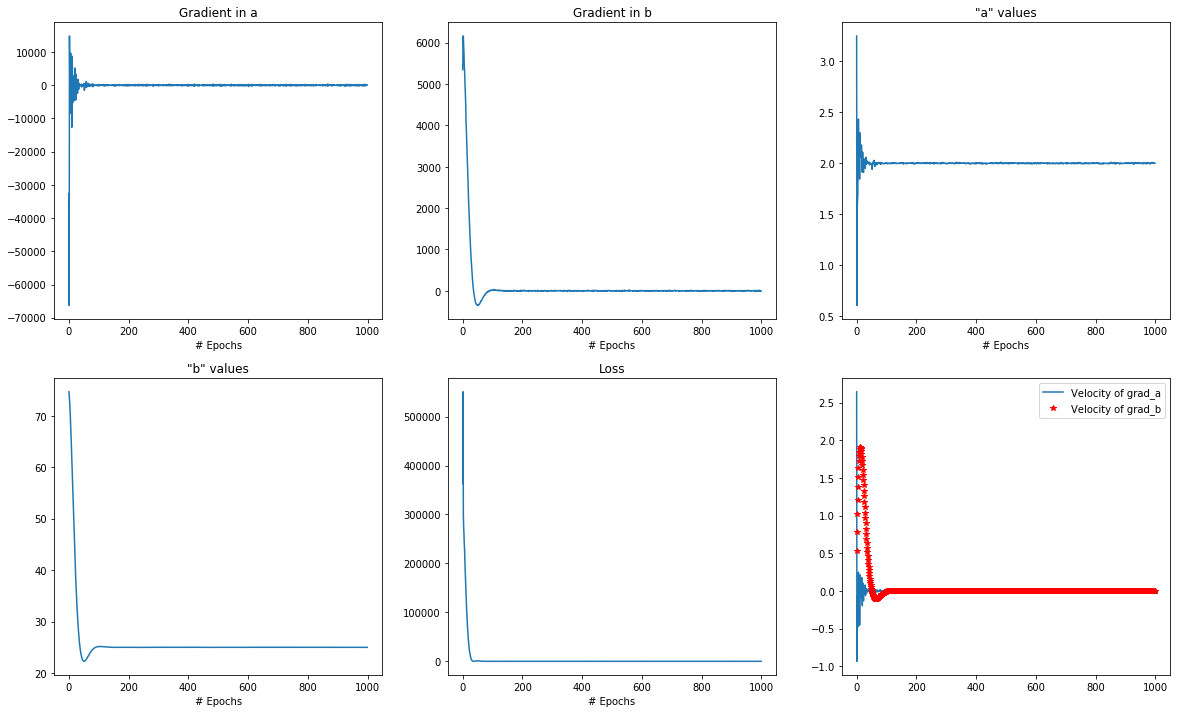

In [14]:
plot_all_results(grad_store, abvalue_store, loss_store, velocity_store)

### Adagrad

Adagrad is an algorithm for gradient-based optimization that does just this: It adapts the learning rate to the parameters, performing larger updates for infrequent and smaller updates for frequent parameters. For this reason, it is well-suited for dealing with sparse data.

$$
a_{t+1,i} = a_{t,i} - \frac{\eta }{G_{t,ii} + \epsilon} \cdot g_{t,i} 
$$

where $G_t \in R^{d×d}$ is a diagonal matrix where each diagonal element i, i is the sum of the squares of the
gradients w.r.t. the parameter up to time step $t^{i}$, while $\epsilon$ is a smoothing term that avoids division by zero (usually
on the order of 1e-8)

In [15]:
initial_a = 8
initial_b = 75
num_epochs = 3000 # It shouldn't take these many ideally - check b again
eta = 9e-1  # Keep this one high for adagrad...
batch_size = 128
eps = 1e-8

grad_store, abvalue_store, loss_store, _ = get_data_stores(num_epochs)

a_opt = initial_a
b_opt = initial_b
abvalue_store[0,:] = [a_opt, b_opt]


x_batch, y_batch = get_random_batch(x,y, batch_size)
grad_a, grad_b, loss = gradient(x_batch,y_batch, initial_a, initial_b)
grad_store[0,:] = [grad_a, grad_b]
abvalue_store[0,:] = [a_opt, b_opt]
loss_store[0] = loss

for i in range(1,num_epochs):
    a_opt = a_opt - eta * grad_a / np.sqrt(sum(np.power(grad_store[:i,0],2)) + eps)
    b_opt = b_opt - eta * grad_b / np.sqrt(sum(np.power(grad_store[:i,1],2)) + eps)
    x_batch, y_batch = get_random_batch(x,y, batch_size)
    grad_a, grad_b, loss = gradient(x_batch, y_batch, a_opt , b_opt)
    grad_store[i,:] = [grad_a, grad_b]
    abvalue_store[i,:] = [a_opt, b_opt]
    loss_store[i] = loss

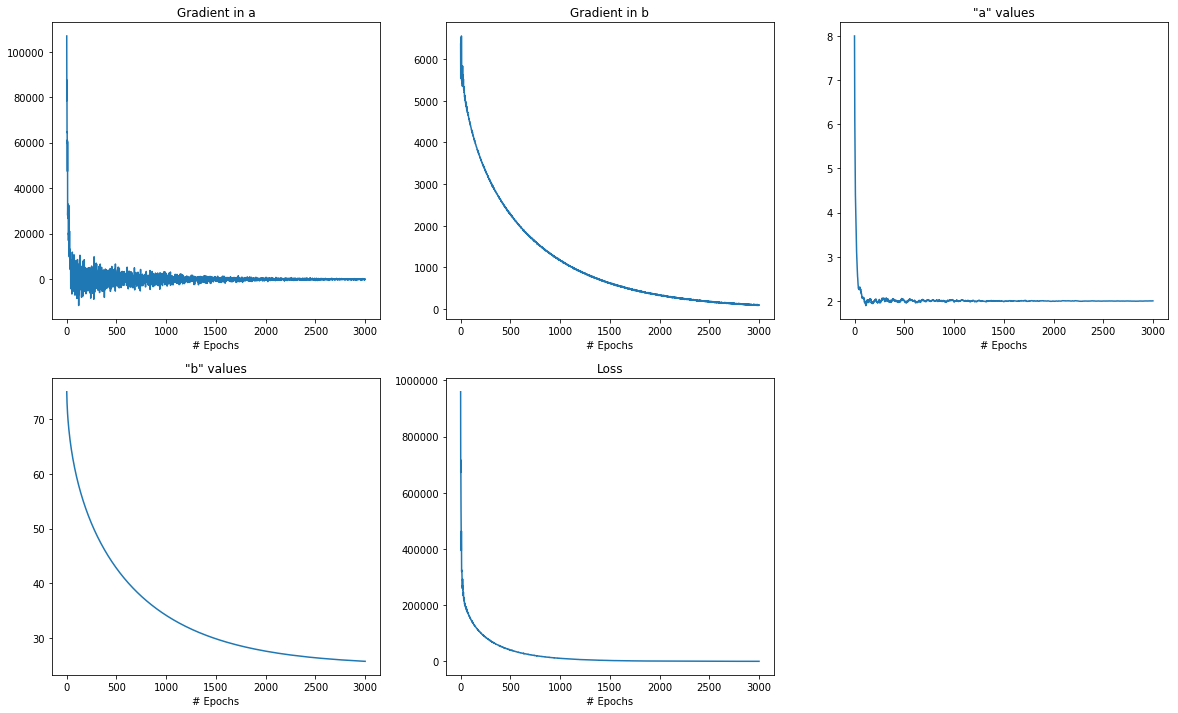

In [16]:
plot_all_results(grad_store, abvalue_store, loss_store)

### Adadelta

Adadelta is an extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate. Instead of accumulating all past squared gradients, Adadelta restricts the window of accumulated past gradients to some fixed size w

In [17]:
def gradient(x, y, a, b):
    temp_err = a * x + b - y
    loss = sum(temp_err * temp_err)
    grad_a = sum(x * temp_err)
    grad_b = sum(temp_err)
    return (grad_a, grad_b, loss)

In [18]:
%%time
initial_a = 8
initial_b = 75
num_epochs = 3000
epsilon = 1e-8
initial_theta = np.array([initial_a, initial_b])
gamma = 0.999
eta = 8e-2
batch_size = 128

grad_store, abvalue_store, loss_store, _ = get_data_stores(num_epochs)

theta = initial_theta

x_batch, y_batch = get_random_batch(x,y, batch_size)
grad_a, grad_b, loss = gradient(x_batch,y_batch, initial_a, initial_b)
grad = np.array([grad_a, grad_b])

expected_grad = np.square(grad)

grad_store[0,:] = list(grad)
abvalue_store[0,:] = list(initial_theta)
loss_store[0,:] = loss

for i in range(1,num_epochs):
    #Basic idea of gradient 
    RMS_grad = np.sqrt(expected_grad + epsilon)
    delta_theta = -(eta/RMS_grad) * grad
    theta = theta + delta_theta
    #Update expected_grad
    x_batch, y_batch = get_random_batch(x,y, batch_size)
    grad_a, grad_b, loss = gradient(x_batch,y_batch, theta[0], theta[1])
    grad = np.array([grad_a, grad_b])
    expected_grad = gamma * expected_grad + (1 - gamma) * np.square(grad)
    
    grad_store[i,:] = list(grad)
    abvalue_store[i,:] = list(theta)
    loss_store[i] = loss
    
    #print grad

CPU times: user 212 ms, sys: 12 ms, total: 224 ms
Wall time: 217 ms


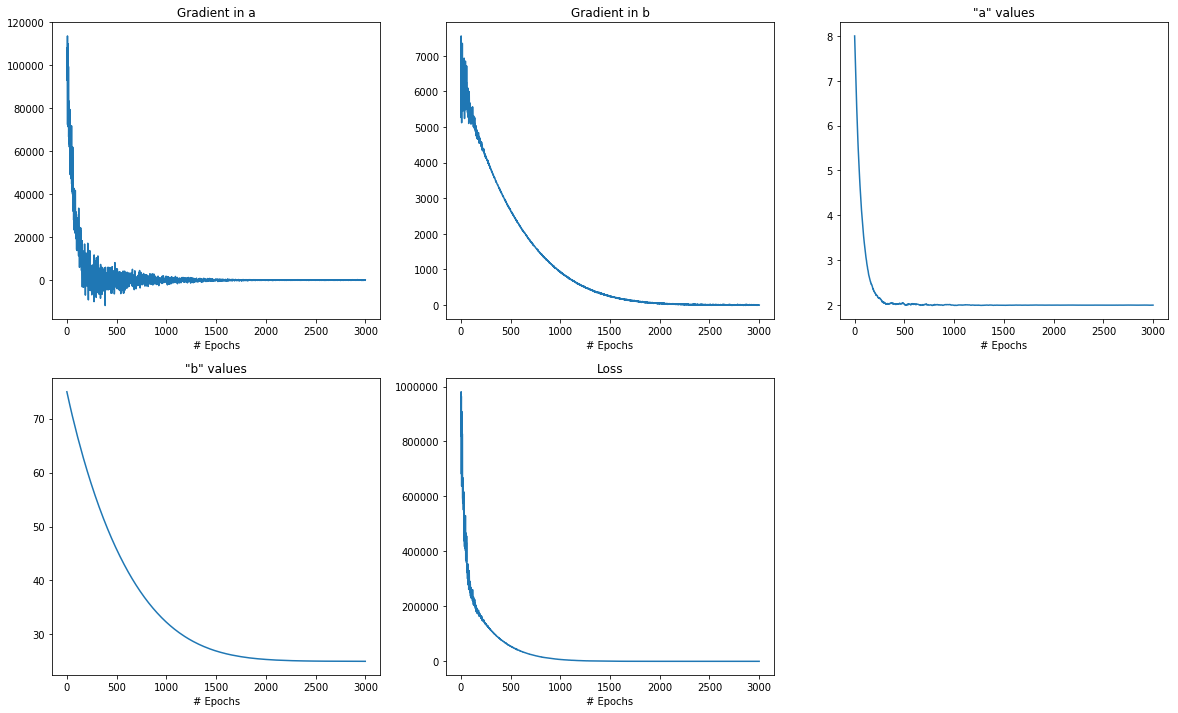

In [19]:

plot_all_results(grad_store, abvalue_store, loss_store)

In [20]:
# For parameter's units correction

In [21]:
%%time
initial_a = 8
initial_b = 75
num_epochs = 2000
epsilon = 1e-8
initial_theta = np.array([initial_a, initial_b])
gamma = 0.9
eta = 1e-1
batch_size = 128

grad_store, abvalue_store, loss_store, _ = get_data_stores(num_epochs)

theta = initial_theta

x_batch, y_batch = get_random_batch(x,y, batch_size)
grad_a, grad_b, loss = gradient(x_batch,y_batch, initial_a, initial_b)
grad = np.array([grad_a, grad_b])

expected_grad = np.square(grad)
delta_theta = -(eta/np.sqrt(expected_grad + epsilon)) * grad                                                                                                                                                                
expected_delta_theta = np.square(delta_theta)

grad_store[0,:] = list(grad)
abvalue_store[0,:] = list(initial_theta)
loss_store[0,:] = loss

theta = theta + delta_theta
x_batch, y_batch = get_random_batch(x,y, batch_size)
grad_a, grad_b, loss = gradient(x_batch,y_batch, theta[0], theta[1])
grad = np.array([grad_a, grad_b])
expected_grad = gamma * expected_grad + (1 - gamma) * np.square(grad)

grad_store[1,:] = list(grad)
abvalue_store[1,:] = list(initial_theta)
loss_store[1,:] = loss

for i in range(2,num_epochs):
    #Basic idea of gradient 
    rms_delta_theta = np.sqrt(expected_delta_theta + epsilon)
    rms_grad = np.sqrt(expected_grad + epsilon)
    delta_theta = - grad * (rms_delta_theta /(rms_grad))
    
    theta = theta + delta_theta
    
    #theta = theta + expected_delta_theta
    #Update expected_grad
    x_batch, y_batch = get_random_batch(x,y, batch_size)
    grad_a, grad_b, loss = gradient(x_batch,y_batch, theta[0], theta[1])
    
    grad = np.array([grad_a, grad_b])
    
    expected_grad = gamma * expected_grad + (1 - gamma) * np.square(grad)
    expected_delta_theta = gamma * expected_delta_theta + (1-gamma) * np.square(delta_theta)
    
    grad_store[i,:] = list(grad)
    abvalue_store[i,:] = list(theta)
    loss_store[i] = loss
    
    #print grad

CPU times: user 156 ms, sys: 10.6 ms, total: 167 ms
Wall time: 155 ms


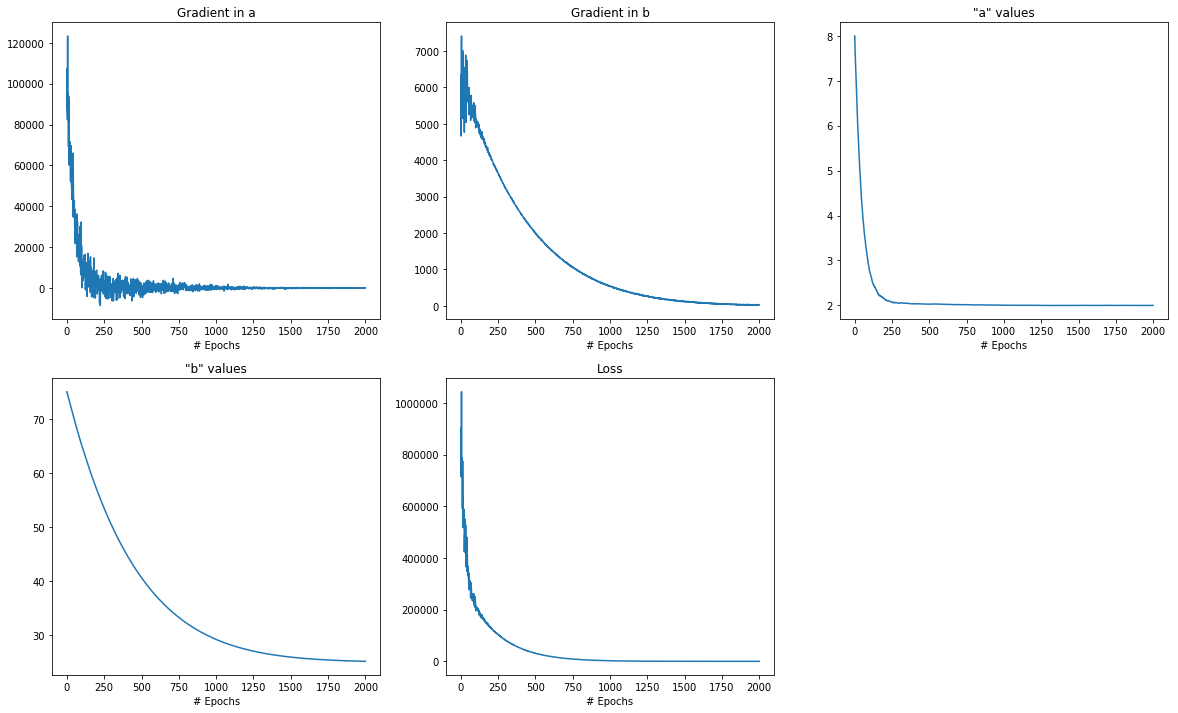

In [22]:
plot_all_results(grad_store, abvalue_store, loss_store)

### Adam

Adaptive Moment Estimation (Adam) is another method that computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients $v_t$ like Adadelta and RMSprop, Adam also keeps an exponentially decaying average of past gradients $m_t$, similar to momentum

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1)g_t
$$

$$
v_t = \beta_2v_{t-1} + (1 - \beta_2)g^2_t 
$$

$$
\hat{m_t} = \frac{m_t}{1 - \beta_t}
$$

In [23]:
%%time
initial_a = 8
initial_b = 75
num_epochs = 2000
epsilon = 1e-8

theta = np.array([initial_a, initial_b])
beta1 = 0.9
beta2 = 0.999
batch_size = 1024
eta = 1e-1
grad_store, abvalue_store, loss_store, velocity_store = get_data_stores(num_epochs)


mt = np.array([0, 0])
vt = np.array([0, 0])

for i in range(num_epochs): 
    t = i+1
    #Update expected_grad
    x_batch, y_batch = get_random_batch(x,y, batch_size)
    
    grad_a, grad_b, loss = gradient(x_batch,y_batch, theta[0], theta[1])
    grad = np.array([grad_a, grad_b])
    
    mt = (beta1 * mt + (1 - beta1) * grad)
    vt = (beta2 * vt + (1 - beta2) * (grad ** 2))
    
    mhat = mt / (1 - beta1 ** t ) 
    vhat = vt / (1 - beta2 ** t )
    
    grad_store[i,:] = list(grad)
    abvalue_store[i,:] = list(theta)
    loss_store[i] = loss
    
#     print vhat
    
    #Basic idea of gradient 
    delta_theta = -1 * eta * mhat/(np.sqrt(vhat) + epsilon)
    theta = theta + delta_theta

CPU times: user 702 ms, sys: 943 µs, total: 703 ms
Wall time: 703 ms


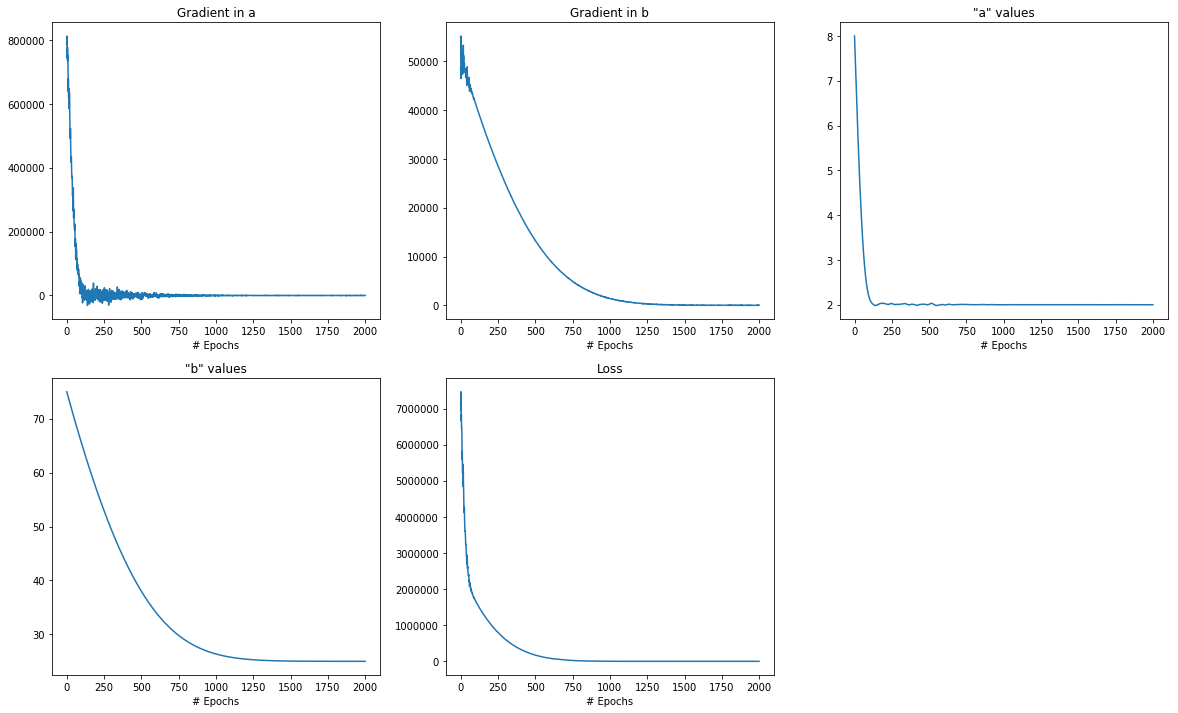

In [24]:
plot_all_results(grad_store, abvalue_store, loss_store)

## AdaMax
Norms for large p values generally become numerically unstable, which is why $l_1$ and $l_2$ norms are
most common in practice. However, $l_\infty$ also generally exhibits stable behavior. For this reason, the
authors propose AdaMax and show that vt with $l_\infty$ converges to the following more stable value
$$
u_t = \beta^\infty_2 v_{t-1} + (1 - \beta_2^\infty)|g_t|^\infty
$$

$$
u_t = max(\beta_2 \cdot v_{t-1}, |g_t|) 
$$

$$
\theta_{t+1} = \theta_t - \eta \frac{\hat{m_t}}{u_t}
$$

In [25]:
%%time
initial_a = 8
initial_b = 75
num_epochs = 2000
epsilon = 1e-8

theta = np.array([initial_a, initial_b])
beta1 = 0.9
beta2 = 0.999
batch_size = 1024
eta = 1e-1
grad_store, abvalue_store, loss_store, velocity_store = get_data_stores(num_epochs)


mt = np.array([0, 0])
vt = np.array([0, 0])

for i in range(num_epochs): 
    t = i+1
    #Update expected_grad
    x_batch, y_batch = get_random_batch(x,y, batch_size)
    
    grad_a, grad_b, loss = gradient(x_batch,y_batch, theta[0], theta[1])
    grad = np.array([grad_a, grad_b])
    
    mt = (beta1 * mt + (1 - beta1) * grad)
    vt = (beta2 * vt + (1 - beta2) * (grad ** 2))
    
    ut = np.max(np.append(beta2 * vt, grad, axis=0), axis=0)
    
    mhat = mt / (1 - beta1 ** t ) 
#     vhat = vt / (1 - beta2 ** t )
    
    grad_store[i,:] = list(grad)
    abvalue_store[i,:] = list(theta)
    loss_store[i] = loss
    
#     print vhat
    
    #Basic idea of gradient 
    delta_theta = -1 * eta * mhat/(np.sqrt(ut) + epsilon)
    theta = theta + delta_theta

CPU times: user 700 ms, sys: 2.11 ms, total: 702 ms
Wall time: 700 ms


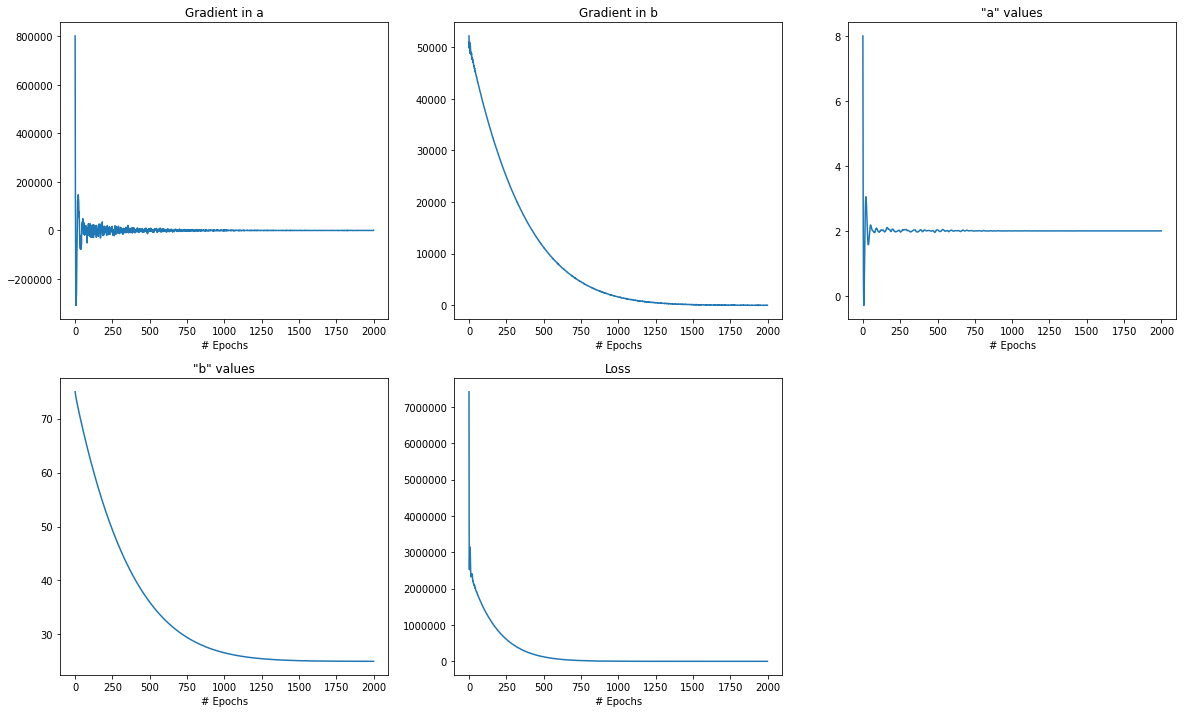

In [26]:
plot_all_results(grad_store, abvalue_store, loss_store)

### Nadam
Nadam (Nesterov-accelerated Adaptive Moment Estimation) combines Adam and NAG. In order to incorporate NAG into Adam, we need to modify its momentum term $m_t$
$$
    \theta_{t+1} = \theta_{t} - \frac{\eta}{\sqrt{v_t} + \epsilon} (\beta_1 \hat{m_t} + \frac{(1-\beta_1)g_tt}{1-\beta_1^t})
$$

In [27]:
%%time
initial_a = 8
initial_b = 75
num_epochs = 2000
epsilon = 1e-8

theta = np.array([initial_a, initial_b])
beta1 = 0.9
beta2 = 0.999
batch_size = 1024
eta = 1e-1
grad_store, abvalue_store, loss_store, velocity_store = get_data_stores(num_epochs)


mt = np.array([0, 0])
vt = np.array([0, 0])

for i in range(num_epochs): 
    t = i+1
    #Update expected_grad
    x_batch, y_batch = get_random_batch(x,y, batch_size)
    
    grad_a, grad_b, loss = gradient(x_batch,y_batch, theta[0], theta[1])
    grad = np.array([grad_a, grad_b])
    
    mt = (beta1 * mt + (1 - beta1) * grad)
    vt = (beta2 * vt + (1 - beta2) * (grad ** 2))
    
    ut = np.max(np.append(beta2 * vt, grad, axis=0), axis=0)
    
    mhat = mt / (1 - beta1 ** t ) 
    vhat = vt / (1 - beta2 ** t )
    
    grad_store[i,:] = list(grad)
    abvalue_store[i,:] = list(theta)
    loss_store[i] = loss
    
    
    #Basic idea of gradient 
    delta_theta = -1 * eta * (beta1 * mhat + (1 - beta1)/(1 - beta1 ** t) * grad)/(np.sqrt(ut) + epsilon)
    theta = theta + delta_theta

CPU times: user 727 ms, sys: 34 µs, total: 727 ms
Wall time: 727 ms


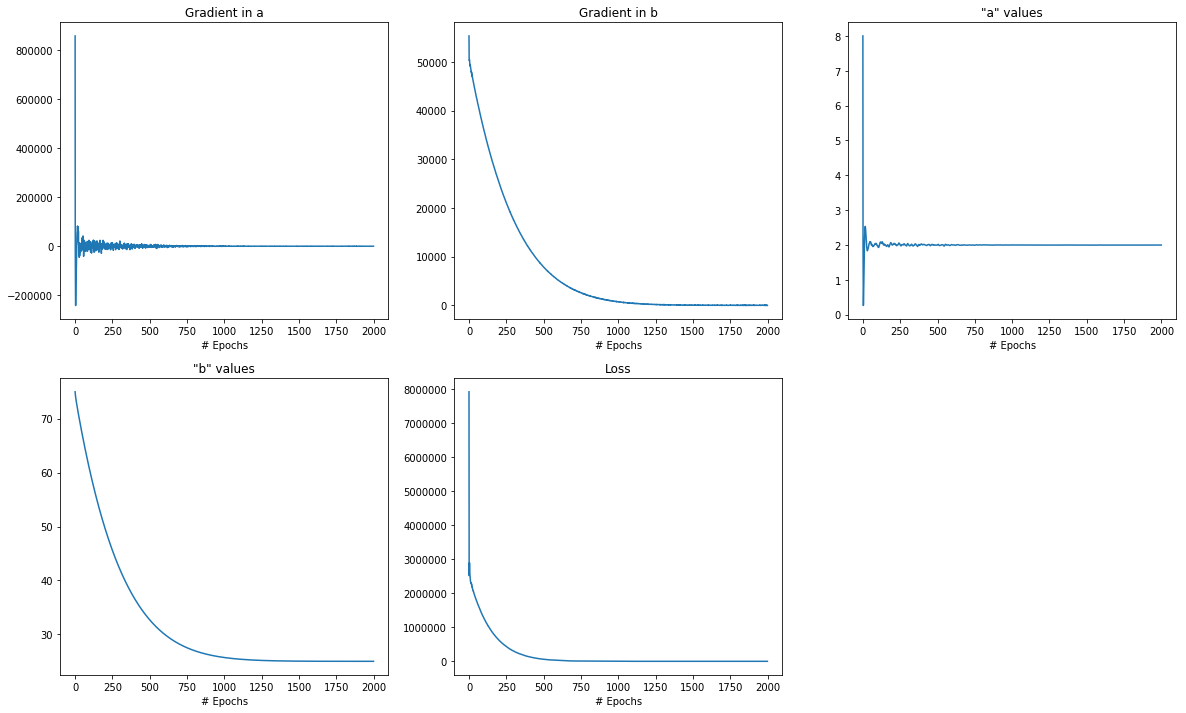

In [28]:
plot_all_results(grad_store, abvalue_store, loss_store)

### More exciting stuff coming soon

Thank you for reading. The github repo with the latest version of this notebook can be found at https://github.com/falaktheoptimist/gradient_descent_optimizers 